In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
import theano
import arviz as az

from scipy import stats
import xarray as xr

import itertools
from theano import tensor as tt

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,5)
#WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.

In [15]:
data = pd.read_csv("./IMA_recommendation_simulation_data.csv")
data = data.dropna()

#data = data.iloc[0:8000,]

In [16]:
data.shape
data.head()

,Unnamed: 0,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition
0,0,c2653eda11cd4d94879d1946392eb2b5,4,Sat,1856,V,1848.0,2,40000.0,3,RED,633,978,2.273442,2.138631,Accepted
1,1,65e3dcc84a2246e68ea8636a967b31b2,3,Mon,56,V,47.0,2,12729.0,3,RED,604,604,-0.971030,-1.017024,Rejected
2,2,0a86f005640a4204b46c95ca033a7ced,1,Fri,259,V,255.0,2,44176.0,3,RED,761,770,-0.393352,-0.475805,Accepted
3,3,1105b4bc7b444f7985d4ad810e7acbc2,3,Thu,71,V,68.0,2,39847.0,6,RED,187,180,-0.706546,-0.765855,Rejected
4,4,de538100bb0f4137961b9551640ef35e,3,Fri,1182,R,1183.0,2,34912.0,3,GREEN,972,922,1.014233,0.469273,Accepted


In [17]:
# Adding Zip Zone information
def zz(value):
    if value < 100:
        return 'Z0'
    elif value < 200:
        return 'Z1'
    elif value < 300:
        return 'Z2'
    elif value < 400:
        return 'Z3'
    elif value < 500:
        return 'Z4'
    elif value < 600:
        return 'Z5'
    elif value < 700:
        return 'Z6'
    elif value < 800:
        return 'Z7'
    elif value < 900:
        return 'Z8'
    elif value < 1000:
        return 'Z9'
    else:
        return 'Error'


data['ZipZone_origin'] = data.apply(lambda column: zz(column['origin_dat_ref']),axis=1)
data['ZipZone_dest'] = data.apply(lambda column: zz(column['dest_dat_ref']),axis=1)

In [18]:
data['ZipZone_pair'] = data.apply(lambda column: (column['ZipZone_origin'], column['ZipZone_dest']), axis=1)
data.head()

,Unnamed: 0,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition,ZipZone_origin,ZipZone_dest,ZipZone_pair
0,0,c2653eda11cd4d94879d1946392eb2b5,4,Sat,1856,V,1848.0,2,40000.0,3,RED,633,978,2.273442,2.138631,Accepted,Z6,Z9,"(Z6, Z9)"
1,1,65e3dcc84a2246e68ea8636a967b31b2,3,Mon,56,V,47.0,2,12729.0,3,RED,604,604,-0.971030,-1.017024,Rejected,Z6,Z6,"(Z6, Z6)"
2,2,0a86f005640a4204b46c95ca033a7ced,1,Fri,259,V,255.0,2,44176.0,3,RED,761,770,-0.393352,-0.475805,Accepted,Z7,Z7,"(Z7, Z7)"
3,3,1105b4bc7b444f7985d4ad810e7acbc2,3,Thu,71,V,68.0,2,39847.0,6,RED,187,180,-0.706546,-0.765855,Rejected,Z1,Z1,"(Z1, Z1)"
4,4,de538100bb0f4137961b9551640ef35e,3,Fri,1182,R,1183.0,2,34912.0,3,GREEN,972,922,1.014233,0.469273,Accepted,Z9,Z9,"(Z9, Z9)"


In [19]:
data = data[data['lead_days'] >= 0]

In [20]:
data['order_distance_norm'] = (data['order_distance'] - data['order_distance'].mean())/(data['order_distance'].std())
data['weight_norm'] = (data['order_origin_weight'] - data['order_origin_weight'].mean())/(data['order_origin_weight'].std())
data['lead_days_norm'] = (data['lead_days'] - data['lead_days'].mean())/(data['lead_days'].std())
data['week_id_norm'] = (data['week_id'] - data['week_id'].mean())/(data['week_id'].std())

In [21]:
#zipzone_origin_idx, zipzones = pd.factorize(data_sub['ZipZone_origin'], sort=True)
#zipzone_dest_idx,_ = pd.factorize(data_sub['ZipZone_dest'], sort=True)

zipzone_pair_id, zipzone_pairs = pd.factorize(data['ZipZone_pair'], sort=True)

In [22]:
zipzone_pairs # zipzone_pair_idx[i] = j means that in the unsorted list of zipzone_pairs, the ith entry is actually the jth entry in the sorted list

# zipzone_pair_idx[8] corresponds to (Z3, Z3)
# zipzone_pair_idx[4] corresponds to (Z9, Z9)
# zipzone_pair_idx[2] corresponds to (Z7, Z7)

Index([('Z0', 'Z0'), ('Z0', 'Z1'), ('Z0', 'Z2'), ('Z0', 'Z3'), ('Z0', 'Z4'),
       ('Z0', 'Z5'), ('Z0', 'Z6'), ('Z0', 'Z7'), ('Z0', 'Z8'), ('Z0', 'Z9'),
       ('Z1', 'Z0'), ('Z1', 'Z1'), ('Z1', 'Z2'), ('Z1', 'Z3'), ('Z1', 'Z4'),
       ('Z1', 'Z5'), ('Z1', 'Z6'), ('Z1', 'Z7'), ('Z1', 'Z8'), ('Z1', 'Z9'),
       ('Z2', 'Z0'), ('Z2', 'Z1'), ('Z2', 'Z2'), ('Z2', 'Z3'), ('Z2', 'Z4'),
       ('Z2', 'Z5'), ('Z2', 'Z6'), ('Z2', 'Z7'), ('Z2', 'Z8'), ('Z2', 'Z9'),
       ('Z3', 'Z0'), ('Z3', 'Z1'), ('Z3', 'Z2'), ('Z3', 'Z3'), ('Z3', 'Z4'),
       ('Z3', 'Z5'), ('Z3', 'Z6'), ('Z3', 'Z7'), ('Z3', 'Z8'), ('Z3', 'Z9'),
       ('Z4', 'Z0'), ('Z4', 'Z1'), ('Z4', 'Z2'), ('Z4', 'Z3'), ('Z4', 'Z4'),
       ('Z4', 'Z5'), ('Z4', 'Z6'), ('Z4', 'Z7'), ('Z4', 'Z8'), ('Z4', 'Z9'),
       ('Z5', 'Z0'), ('Z5', 'Z1'), ('Z5', 'Z2'), ('Z5', 'Z3'), ('Z5', 'Z4'),
       ('Z5', 'Z5'), ('Z5', 'Z6'), ('Z5', 'Z7'), ('Z5', 'Z8'), ('Z5', 'Z9'),
       ('Z6', 'Z0'), ('Z6', 'Z1'), ('Z6', 'Z2'), ('Z6', 'Z3'), ('Z6', 'Z4'),

In [23]:
df_order_Z33 = data[(data['ZipZone_origin'] == 'Z3') & (data['ZipZone_dest'] == 'Z3')]
df_order_Z77 = data[(data['ZipZone_origin'] == 'Z7') & (data['ZipZone_dest'] == 'Z7')]
df_order_Z99 = data[(data['ZipZone_origin'] == 'Z9') & (data['ZipZone_dest'] == 'Z9')]

In [24]:
coords = {
    "obs_id": np.arange((data.shape)[0]),
    "zipzone_pair": zipzone_pairs,
    "num_coef": np.arange(5)
}

In [25]:
order_distance_norm = data.order_distance_norm
weight_norm = data.weight_norm
lead_days_norm = data.lead_days_norm
week_id_norm = data.week_id_norm
rate_norm = data.rate_norm
est_cost_norm = data.est_cost_norm

order_distance_norm = np.array(order_distance_norm.values.tolist())
weight_norm = np.array(weight_norm.values.tolist())
lead_days_norm = np.array(lead_days_norm.values.tolist())
week_id_norm = np.array(week_id_norm.values.tolist())
rate_norm = np.array(rate_norm.values.tolist())
est_cost_norm = np.array(est_cost_norm.tolist())

## Final rate model

In [26]:
with pm.Model(coords=coords) as rate_model_1:
    zipzone_pair_idx = pm.Data("zipzone_pair_idx", zipzone_pair_id, dims = 'obs_id')
    x1_shared = pm.Data("distance", order_distance_norm, dims = 'obs_id')
    x2_shared = pm.Data("weight", weight_norm, dims = 'obs_id')
    x3_shared = pm.Data("leaddays", lead_days_norm, dims = 'obs_id')
    x4_shared = pm.Data("weekid", week_id_norm, dims = 'obs_id')
    y_shared = pm.Data("rate", rate_norm, dims = 'obs_id')
    
    
    sd_dist = pm.Exponential.dist(1.0)
    
    
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=5, eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    
    mu_intercept = pm.Normal('mu_intercept', mu=0, sigma=1)
    mu_distance = pm.Normal('mu_distance', mu=0, sigma=1)
    mu_weight = pm.Normal('mu_weight', mu=0, sigma=1)
    mu_leaddays = pm.Normal('mu_leaddays', mu=0, sigma=1)
    mu_weekid = pm.Normal('mu_weekid', mu=0, sigma=1)
    
    
    cov_coef = pm.MvNormal("cov_coef", mu=tt.stack([mu_intercept, mu_distance, mu_weight, mu_leaddays, mu_weekid]), 
                           chol=chol, dims = ('zipzone_pair', 'num_coef'))
    
    
    # Model error
    epsilon = pm.HalfNormal('epsilon', 1) # Possibly change distribution
    
    # Regression for mean of likelihood
    y_hat = cov_coef[zipzone_pair_idx, 0] + cov_coef[zipzone_pair_idx, 1] * x1_shared + cov_coef[zipzone_pair_idx,2] * x2_shared + cov_coef[zipzone_pair_idx, 3] * x3_shared + cov_coef[zipzone_pair_idx, 4] * x4_shared

    
    # Likelihood
    pm.StudentT('y_like', nu=5, mu=y_hat, sigma=epsilon, observed=y_shared, dims = 'obs_id')
    
    
    rate_trace_1 = pm.sample(1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, cov_coef, mu_weekid, mu_leaddays, mu_weight, mu_distance, mu_intercept, chol]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 535 seconds.


0, dim: obs_id, 7934 =? 7934


The estimated number of effective samples is smaller than 200 for some parameters.


In [27]:
with rate_model_1:
    rate_post_pred_11 = pm.sample_posterior_predictive(rate_trace_1, var_names = ['y_like'])

In [28]:
rate_post_pred_11['y_like'].shape

(2000, 7934)

<AxesSubplot:xlabel='y_like'>

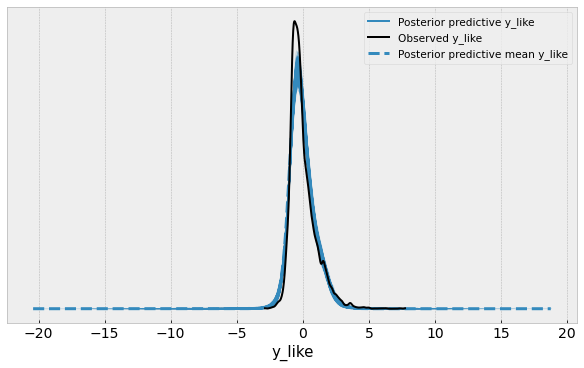

In [29]:
az.plot_ppc(az.from_pymc3(posterior_predictive=rate_post_pred_11, model=rate_model_1))

In [ ]:
summary = az.summary(rate_trace_1, round_to=8)
summary

In [ ]:
from pymc3 import traceplot

traceplot(rate_trace_1)

## Use this model to predict rate_norm on just Z3->Z3 data

In [ ]:
Z3_data = data[(data['ZipZone_origin'] == 'Z3') & (data['ZipZone_dest'] == 'Z3')]

Z3_distance = Z3_data.order_distance_norm
Z3_distance = np.array(Z3_distance.values.tolist())

Z3_weight = Z3_data.weight_norm
Z3_weight = np.array(Z3_weight.values.tolist())

Z3_leaddays = Z3_data.lead_days_norm
Z3_leaddays = np.array(Z3_leaddays.values.tolist())

Z3_weekid = Z3_data.week_id_norm
Z3_weekid = np.array(Z3_weekid.values.tolist())

In [ ]:
#prediction_coords = {"obs_id": [('Z3', 'Z3')]}
with rate_model_1:
    # change the value and shape of the data
    pm.set_data(
        {
            "zipzone_pair_idx": np.tile(zipzone_pair_id[8], (data.shape)[0]),
            "distance": np.concatenate((Z3_distance, np.empty((data.shape)[0] - len(Z3_distance)))),
            "weight": np.concatenate((Z3_weight, np.empty((data.shape)[0] - len(Z3_weight)))),
            "leaddays": np.concatenate((Z3_leaddays, np.empty((data.shape)[0] - len(Z3_leaddays)))),
            "weekid": np.concatenate((Z3_weekid, np.empty((data.shape)[0] - len(Z3_weekid)))),
            # use dummy values with the same shape:
            "rate": np.empty(data.shape[0]),
        }
    )
    rate_post_pred_12 = pm.sample_posterior_predictive(rate_trace_1, var_names=['y_like'])
    #az.from_pymc3_predictions(rate_post_pred_12, idata_orig=rate_trace_1, inplace=True, coords=prediction_coords)

In [ ]:
#az.plot_posterior(rate_trace_1);
az.plot_ppc(az.from_pymc3(posterior_predictive=rate_post_pred_12, model=rate_model_1))

In [ ]:
# Generate the actual prediction values
p_test_pred = rate_post_pred_12["y_like"].mean(axis=0)

In [ ]:
# Plot original Z3 data with generated values

fig, ax = plt.subplots()
x = p_test_pred[0:len(Z3_distance)]
y = Z3_data['rate_norm']
for a in [x, y]:
    sns.distplot(a, bins=100, ax=ax)
#ax.set_xlim([0, 100])

## Final cost model

In [30]:
with pm.Model(coords=coords) as cost_model_1:
    zipzone_pair_idx = pm.Data("zipzone_pair_idx", zipzone_pair_id, dims = 'obs_id')
    x1_shared = pm.Data("distance", order_distance_norm, dims = 'obs_id')
    x2_shared = pm.Data("weight", weight_norm, dims = 'obs_id')
    x3_shared = pm.Data("leaddays", lead_days_norm, dims = 'obs_id')
    x4_shared = pm.Data("weekid", week_id_norm, dims = 'obs_id')
    y_shared = pm.Data("cost", est_cost_norm, dims = 'obs_id')
    
    
    sd_dist = pm.Exponential.dist(1.0)
    
    
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=5, eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    
    mu_intercept = pm.Normal('mu_intercept', mu=0, sigma=1)
    mu_distance = pm.Normal('mu_distance', mu=0, sigma=1)
    mu_weight = pm.Normal('mu_weight', mu=0, sigma=1)
    mu_leaddays = pm.Normal('mu_leaddays', mu=0, sigma=1)
    mu_weekid = pm.Normal('mu_weekid', mu=0, sigma=1)
    
    
    cov_coef = pm.MvNormal("cov_coef", mu=tt.stack([mu_intercept, mu_distance, mu_weight, mu_leaddays, mu_weekid]), 
                           chol=chol, dims = ('zipzone_pair', 'num_coef'))
    
    
    # Model error
    epsilon = pm.HalfNormal('epsilon', 1) # Possibly change distribution
    
    # Regression for mean of likelihood
    y_hat = cov_coef[zipzone_pair_idx, 0] + cov_coef[zipzone_pair_idx, 1] * x1_shared + cov_coef[zipzone_pair_idx,2] * x2_shared + cov_coef[zipzone_pair_idx, 3] * x3_shared + cov_coef[zipzone_pair_idx, 4] * x4_shared

    
    # Likelihood
    pm.StudentT('y_like', nu=5,  mu=y_hat, sigma=epsilon, observed=y_shared, dims = 'obs_id')
    
    
    cost_trace_1 = pm.sample(1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, cov_coef, mu_weekid, mu_leaddays, mu_weight, mu_distance, mu_intercept, chol]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 607 seconds.


0, dim: obs_id, 7934 =? 7934


The estimated number of effective samples is smaller than 200 for some parameters.


In [31]:
with cost_model_1:
    cost_post_pred_11 = pm.sample_posterior_predictive(cost_trace_1, var_names = ['y_like'])

In [ ]:
cost_post_pred_11['y_like'].shape

<AxesSubplot:xlabel='y_like'>

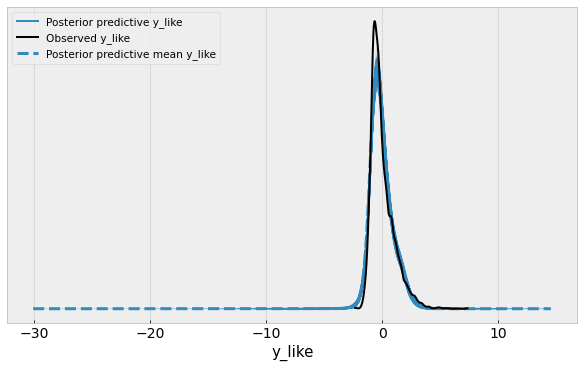

In [32]:
az.plot_ppc(az.from_pymc3(posterior_predictive=cost_post_pred_11, model=cost_model_1))

In [ ]:
summary = az.summary(cost_trace_1, round_to=8)
summary

In [ ]:
from pymc3 import traceplot

traceplot(cost_trace_1)

In [ ]:
# Note: we can also test this model on the Z3->Z3 data (like we did with the rate_norm model) to see how good it fits

# Calling the model using Synthetic Data
### Note: The definitions of the functions below are redundant and can easily be simplified

In [33]:
import scipy.stats as st
from scipy.stats import multinomial
import statsmodels.datasets

In [42]:
def synthetic_data_rate_Z3(generated_distance, generated_weight, generated_lead_days, generated_week_id):
    generated_data = pd.DataFrame({'order_distance': generated_distance, 'order_origin_weight': generated_weight, 
                                   'lead_days': generated_lead_days, 'week_id' : generated_week_id})

    generated_data['order_distance_norm'] = (generated_data['order_distance'] - generated_data['order_distance'].mean())/(generated_data['order_distance'].std())
    generated_data['weight_norm'] = (generated_data['order_origin_weight'] - generated_data['order_origin_weight'].mean())/(generated_data['order_origin_weight'].std())
    generated_data['lead_days_norm'] = (generated_data['lead_days'] - generated_data['lead_days'].mean())/(generated_data['lead_days'].std())
    generated_data['week_id_norm'] = (generated_data['week_id'] - generated_data['week_id'].mean())/(generated_data['week_id'].std())
   

    gen_distance = np.array(generated_data.order_distance_norm.values.tolist())
    gen_weight = np.array(generated_data.weight_norm.values.tolist())
    gen_leaddays = np.array(generated_data.lead_days_norm.values.tolist())
    gen_weekid = np.array(generated_data.week_id_norm.values.tolist())
    
    with rate_model_1:
    # change the value and shape of the data
        pm.set_data(
            {
                "zipzone_pair_idx": np.tile(zipzone_pair_id[8], (data.shape)[0]),
                "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
                "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
                "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
                "weekid": np.concatenate((gen_weekid, np.empty((data.shape)[0] - len(gen_weekid)))),
                # use dummy values with the same shape:
                "rate": np.empty(data.shape[0]),
            }
        )
        rate_post_pred_13 = pm.sample_posterior_predictive(rate_trace_1, var_names=['y_like'])
    
    #rate_pred_13 = rate_post_pred_13["y_like"].mean(axis=0)
    return rate_post_pred_13['y_like'][0,0:len(gen_distance)]

In [43]:
def synthetic_data_rate_Z9(generated_distance, generated_weight, generated_lead_days, generated_week_id):
    generated_data = pd.DataFrame({'order_distance': generated_distance, 'order_origin_weight': generated_weight, 
                                   'lead_days': generated_lead_days, 'week_id' : generated_week_id})

    generated_data['order_distance_norm'] = (generated_data['order_distance'] - generated_data['order_distance'].mean())/(generated_data['order_distance'].std())
    generated_data['weight_norm'] = (generated_data['order_origin_weight'] - generated_data['order_origin_weight'].mean())/(generated_data['order_origin_weight'].std())
    generated_data['lead_days_norm'] = (generated_data['lead_days'] - generated_data['lead_days'].mean())/(generated_data['lead_days'].std())
    generated_data['week_id_norm'] = (generated_data['week_id'] - generated_data['week_id'].mean())/(generated_data['week_id'].std())
   

    gen_distance = np.array(generated_data.order_distance_norm.values.tolist())
    gen_weight = np.array(generated_data.weight_norm.values.tolist())
    gen_leaddays = np.array(generated_data.lead_days_norm.values.tolist())
    gen_weekid = np.array(generated_data.week_id_norm.values.tolist())
    
    with rate_model_1:
    # change the value and shape of the data
        pm.set_data(
            {
                "zipzone_pair_idx": np.tile(zipzone_pair_id[4], (data.shape)[0]),
                "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
                "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
                "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
                "weekid": np.concatenate((gen_weekid, np.empty((data.shape)[0] - len(gen_weekid)))),
                # use dummy values with the same shape:
                "rate": np.empty(data.shape[0]),
            }
        )
        rate_post_pred_14 = pm.sample_posterior_predictive(rate_trace_1, var_names=['y_like'])
    
    #rate_pred_14 = rate_post_pred_14["y_like"].mean(axis=0)
    return rate_post_pred_14['y_like'][0,0:len(gen_distance)]

In [44]:
def synthetic_data_rate_Z7(generated_distance, generated_weight, generated_lead_days, generated_week_id):
    generated_data = pd.DataFrame({'order_distance': generated_distance, 'order_origin_weight': generated_weight, 
                                   'lead_days': generated_lead_days, 'week_id' : generated_week_id})

    generated_data['order_distance_norm'] = (generated_data['order_distance'] - generated_data['order_distance'].mean())/(generated_data['order_distance'].std())
    generated_data['weight_norm'] = (generated_data['order_origin_weight'] - generated_data['order_origin_weight'].mean())/(generated_data['order_origin_weight'].std())
    generated_data['lead_days_norm'] = (generated_data['lead_days'] - generated_data['lead_days'].mean())/(generated_data['lead_days'].std())
    generated_data['week_id_norm'] = (generated_data['week_id'] - generated_data['week_id'].mean())/(generated_data['week_id'].std())
   

    gen_distance = np.array(generated_data.order_distance_norm.values.tolist())
    gen_weight = np.array(generated_data.weight_norm.values.tolist())
    gen_leaddays = np.array(generated_data.lead_days_norm.values.tolist())
    gen_weekid = np.array(generated_data.week_id_norm.values.tolist())
    
    with rate_model_1:
    # change the value and shape of the data
        pm.set_data(
            {
                "zipzone_pair_idx": np.tile(zipzone_pair_id[2], (data.shape)[0]),
                "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
                "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
                "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
                "weekid": np.concatenate((gen_weekid, np.empty((data.shape)[0] - len(gen_weekid)))),
                # use dummy values with the same shape:
                "rate": np.empty(data.shape[0]),
            }
        )
        rate_post_pred_15 = pm.sample_posterior_predictive(rate_trace_1, var_names=['y_like'])
    
    #rate_pred_15 = rate_post_pred_15["y_like"].mean(axis=0)
    return rate_post_pred_15['y_like'][0,0:len(gen_distance)]

In [45]:
def synthetic_data_cost_Z3(generated_distance, generated_weight, generated_lead_days, generated_week_id):
    generated_data = pd.DataFrame({'order_distance': generated_distance, 'order_origin_weight': generated_weight, 
                                   'lead_days': generated_lead_days, 'week_id' : generated_week_id})

    generated_data['order_distance_norm'] = (generated_data['order_distance'] - generated_data['order_distance'].mean())/(generated_data['order_distance'].std())
    generated_data['weight_norm'] = (generated_data['order_origin_weight'] - generated_data['order_origin_weight'].mean())/(generated_data['order_origin_weight'].std())
    generated_data['lead_days_norm'] = (generated_data['lead_days'] - generated_data['lead_days'].mean())/(generated_data['lead_days'].std())
    generated_data['week_id_norm'] = (generated_data['week_id'] - generated_data['week_id'].mean())/(generated_data['week_id'].std())
   

    gen_distance = np.array(generated_data.order_distance_norm.values.tolist())
    gen_weight = np.array(generated_data.weight_norm.values.tolist())
    gen_leaddays = np.array(generated_data.lead_days_norm.values.tolist())
    gen_weekid = np.array(generated_data.week_id_norm.values.tolist())
    
    with cost_model_1:
    # change the value and shape of the data
        pm.set_data(
            {
                "zipzone_pair_idx": np.tile(zipzone_pair_id[8], (data.shape)[0]),
                "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
                "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
                "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
                "weekid": np.concatenate((gen_weekid, np.empty((data.shape)[0] - len(gen_weekid)))),
                # use dummy values with the same shape:
                "cost": np.empty(data.shape[0]),
            }
        )
        cost_post_pred_13 = pm.sample_posterior_predictive(cost_trace_1, var_names=['y_like'])
    
    #cost_pred_13 = cost_post_pred_13["y_like"].mean(axis=0)
    return cost_post_pred_13['y_like'][0,0:len(gen_distance)]

In [46]:
def synthetic_data_cost_Z9(generated_distance, generated_weight, generated_lead_days, generated_week_id):
    generated_data = pd.DataFrame({'order_distance': generated_distance, 'order_origin_weight': generated_weight, 
                                   'lead_days': generated_lead_days, 'week_id' : generated_week_id})

    generated_data['order_distance_norm'] = (generated_data['order_distance'] - generated_data['order_distance'].mean())/(generated_data['order_distance'].std())
    generated_data['weight_norm'] = (generated_data['order_origin_weight'] - generated_data['order_origin_weight'].mean())/(generated_data['order_origin_weight'].std())
    generated_data['lead_days_norm'] = (generated_data['lead_days'] - generated_data['lead_days'].mean())/(generated_data['lead_days'].std())
    generated_data['week_id_norm'] = (generated_data['week_id'] - generated_data['week_id'].mean())/(generated_data['week_id'].std())
   

    gen_distance = np.array(generated_data.order_distance_norm.values.tolist())
    gen_weight = np.array(generated_data.weight_norm.values.tolist())
    gen_leaddays = np.array(generated_data.lead_days_norm.values.tolist())
    gen_weekid = np.array(generated_data.week_id_norm.values.tolist())
    
    with cost_model_1:
    # change the value and shape of the data
        pm.set_data(
            {
                "zipzone_pair_idx": np.tile(zipzone_pair_id[4], (data.shape)[0]),
                "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
                "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
                "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
                "weekid": np.concatenate((gen_weekid, np.empty((data.shape)[0] - len(gen_weekid)))),
                # use dummy values with the same shape:
                "cost": np.empty(data.shape[0]),
            }
        )
        cost_post_pred_14 = pm.sample_posterior_predictive(cost_trace_1, var_names=['y_like'])
    
    #cost_pred_14 = cost_post_pred_14["y_like"].mean(axis=0)
    return cost_post_pred_14['y_like'][0,0:len(gen_distance)]

In [47]:
def synthetic_data_cost_Z7(generated_distance, generated_weight, generated_lead_days, generated_week_id):
    generated_data = pd.DataFrame({'order_distance': generated_distance, 'order_origin_weight': generated_weight, 
                                   'lead_days': generated_lead_days, 'week_id' : generated_week_id})

    generated_data['order_distance_norm'] = (generated_data['order_distance'] - generated_data['order_distance'].mean())/(generated_data['order_distance'].std())
    generated_data['weight_norm'] = (generated_data['order_origin_weight'] - generated_data['order_origin_weight'].mean())/(generated_data['order_origin_weight'].std())
    generated_data['lead_days_norm'] = (generated_data['lead_days'] - generated_data['lead_days'].mean())/(generated_data['lead_days'].std())
    generated_data['week_id_norm'] = (generated_data['week_id'] - generated_data['week_id'].mean())/(generated_data['week_id'].std())
   

    gen_distance = np.array(generated_data.order_distance_norm.values.tolist())
    gen_weight = np.array(generated_data.weight_norm.values.tolist())
    gen_leaddays = np.array(generated_data.lead_days_norm.values.tolist())
    gen_weekid = np.array(generated_data.week_id_norm.values.tolist())
    
    with cost_model_1:
    # change the value and shape of the data
        pm.set_data(
            {
                "zipzone_pair_idx": np.tile(zipzone_pair_id[2], (data.shape)[0]),
                "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
                "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
                "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
                "weekid": np.concatenate((gen_weekid, np.empty((data.shape)[0] - len(gen_weekid)))),
                # use dummy values with the same shape:
                "cost": np.empty(data.shape[0]),
            }
        )
        cost_post_pred_15 = pm.sample_posterior_predictive(cost_trace_1, var_names=['y_like'])
    
    #cost_pred_15 = cost_post_pred_15["y_like"].mean(axis=0)
    return cost_post_pred_15['y_like'][0,0:len(gen_distance)]

# Data generation

# Z9 to Z9

In [ ]:




#Distance
generated_distance_Z9 = st.genexpon.rvs(a = 0.82, b = 0.61, c=3.91, loc=0.00, scale=767.77, 
                                 size=11000, random_state=43)


#Weight
generated_weight_Z9 = st.foldcauchy.rvs( c=12.30, loc=0.99, scale=3377.58, 
                                 size=11000, random_state=43)


#Lead_days
all = df_order_Z99.shape[0]
p_lead_days_Z9 = np.empty(df_order_Z99['lead_days'].max()+1)
n = 0
while n <= df_order_Z99['lead_days'].max():
    p_lead_days_Z9[n] = df_order_Z99[df_order_Z99['lead_days']==n].shape[0]/all
    n += 1
a_lead_days_Z9 = multinomial.rvs(n=1, p=p_lead_days_Z9, size=11000, random_state=43)
generated_lead_days_Z9 = np.zeros((11000,), dtype=int)
for i in range(11000):
    for j in range(df_order_Z99['lead_days'].max()):
        if a_lead_days_Z9[i,j] == 1:
            generated_lead_days_Z9[i]= j

            
#Week_id            
p_week_id_Z9 =  np.empty(df_order_Z99['week_id'].max()+1) 
n=0
while n <= df_order_Z99['week_id'].max(): 
    p_week_id_Z9[n] = df_order_Z99[df_order_Z99['week_id']==n].shape[0]/all
    n += 1
a_week_id_Z9 = multinomial.rvs(n=1, p=p_week_id_Z9, size=11000, random_state=43)  
generated_week_id_Z9 = np.zeros((11000,), dtype=int)
for i in range(11000):
    for j in range(df_order_Z99['week_id'].max()):
        if a_week_id_Z9[i,j] == 1:
            generated_week_id_Z9[i]= j



#Rate            
generated_rate_Z9 = synthetic_data_rate_Z9(generated_distance_Z9, generated_weight_Z9, generated_lead_days_Z9, generated_week_id_Z9) 


#Cost
generated_cost_Z9 = synthetic_data_cost_Z9(generated_distance_Z9, generated_weight_Z9, generated_lead_days_Z9, generated_week_id_Z9)

generated_data_Z9 = pd.DataFrame({'order_distance': generated_distance_Z9, 'order_origin_weight': generated_weight_Z9, 
                                   'lead_days': generated_lead_days_Z9, 'week_id' : generated_week_id_Z9, 
                                  'rate_norm': generated_rate_Z9, 'est_cost_norm' : generated_cost_Z9 })

# Z3 to Z3

In [50]:


#Distance
generated_distance_Z3 = st.beta.rvs(a = 1.62, b = 14.26, loc=-8.14, scale=2610.99, 
                                 size=13000, random_state=43)

#Weight
generated_weight_Z3 = st.foldcauchy.rvs( c=19.44, loc=1.00, scale=2228.21, 
                                 size=13000, random_state=43)


#Lead_days
all = df_order_Z33.shape[0]
p_lead_days_Z3 = np.empty(df_order_Z33['lead_days'].max()+1)
n = 0
while n <= df_order_Z33['lead_days'].max():
    p_lead_days_Z3[n] = df_order_Z33[df_order_Z33['lead_days']==n].shape[0]/all
    n += 1
a_lead_days_Z3 = multinomial.rvs(n=1, p=p_lead_days_Z3, size=13000, random_state=43)
generated_lead_days_Z3 = np.zeros((13000,), dtype=int)
for i in range(13000):
    for j in range(df_order_Z33['lead_days'].max()):
        if a_lead_days_Z3[i,j] == 1:
            generated_lead_days_Z3[i]= j
            

#Week_id            
p_week_id_Z3 =  np.empty(df_order_Z33['week_id'].max()+1) 
n=0
while n <= df_order_Z33['week_id'].max(): 
    p_week_id_Z3[n] = df_order_Z33[df_order_Z33['week_id']==n].shape[0]/all
    n += 1
a_week_id_Z3= multinomial.rvs(n=1, p=p_week_id_Z3, size=13000, random_state=43)  
generated_week_id_Z3 = np.zeros((13000,), dtype=int)
for i in range(13000):
    for j in range(df_order_Z33['week_id'].max()):
        if a_week_id_Z3[i,j] == 1:
            generated_week_id_Z3[i]= j


#Rate
generated_rate_Z3 = synthetic_data_rate_Z3(generated_distance_Z3, generated_weight_Z3, generated_lead_days_Z3, generated_week_id_Z3) 


#Cost
generated_cost_Z3 = synthetic_data_cost_Z3(generated_distance_Z3, generated_weight_Z3, generated_lead_days_Z3, generated_week_id_Z3)


generated_data_Z3 = pd.DataFrame({'order_distance': generated_distance_Z3, 'order_origin_weight': generated_weight_Z3, 
                                   'lead_days': generated_lead_days_Z3, 'week_id' : generated_week_id_Z3, 
                                  'rate_norm': generated_rate_Z3, 'est_cost_norm' : generated_cost_Z3})

# Z7 to Z7

In [ ]:


# Distance
generated_distance_Z7 = st.dgamma.rvs(a = 0.97, loc=260.00, scale=116.76, 
                                 size=10000, random_state=43)

#Weight
generated_weight_Z7 = st.gennorm.rvs(beta = 0.38, loc=43500.00, scale=214.83, 
                                 size=10000, random_state=43)

#Lead_days
all = df_order_Z77.shape[0]
p_lead_days_Z7 = np.empty(df_order_Z77['lead_days'].max()+1)
n = 0
while n <= df_order_Z77['lead_days'].max():
    p_lead_days_Z7[n] = df_order_Z77[df_order_Z77['lead_days']==n].shape[0]/all
    n += 1
a_lead_days_Z7 = multinomial.rvs(n=1, p=p_lead_days_Z7, size=10000, random_state=43)
generated_lead_days_Z7 = np.zeros((10000,), dtype=int)
for i in range(10000):
    for j in range(df_order_Z77['lead_days'].max()):
        if a_lead_days_Z7[i,j] == 1:
            generated_lead_days_Z7[i]= j
            
#Week_id            
p_week_id_Z7 =  np.empty(df_order_Z77['week_id'].max()+1)
n=0
while n <= df_order_Z77['week_id'].max(): 
    p_week_id_Z7[n] = df_order_Z77[df_order_Z77['week_id']==n].shape[0]/all
    n += 1
a_week_id_Z7 = multinomial.rvs(n=1, p=p_week_id_Z7, size=10000, random_state=43)  
generated_week_id_Z7 = np.zeros((10000,), dtype=int)
for i in range(10000):
    for j in range(df_order_Z77['week_id'].max()):
        if a_week_id_Z7[i,j] == 1:
            generated_week_id_Z7[i]= j


#Rate   
generated_rate_Z7 = synthetic_data_rate_Z7(generated_distance_Z7, generated_weight_Z7, generated_lead_days_Z7, generated_week_id_Z7)  

#Cost
generated_cost_Z7 = synthetic_data_cost_Z7(generated_distance_Z7, generated_weight_Z7, generated_lead_days_Z7, generated_week_id_Z7)    


generated_data_Z7 = pd.DataFrame({'order_distance': generated_distance_Z7, 'order_origin_weight': generated_weight_Z7, 
                                   'lead_days': generated_lead_days_Z7, 'week_id' : generated_week_id_Z7, 
                                  'rate_norm': generated_rate_Z7, 'est_cost_norm' : generated_cost_Z7 })

<AxesSubplot:>

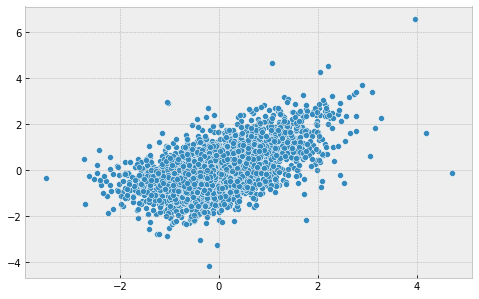

In [51]:
import seaborn as sns

sns.scatterplot(x=generated_rate_Z3, y=generated_cost_Z3)

In [ ]:
sns.scatterplot(x=generated_rate_Z9, y=generated_cost_Z9)

In [ ]:
sns.scatterplot(x=generated_rate_Z7, y=generated_cost_Z7)